<font size=7> Early social distancing: evidence of privilege in a pandemic from smartphone data </font><br>
Nabarun Dasgupta, MPH, PhD | nab@unc.edu | @nabarund<br>
*Dr. Dasgupta is an epidemiologist at the University of North Carolina in Chapel Hill. He studies population level patterns of infectious disease, medication safety, and opioids.*<br>
Thanks to Ben White for data munging help. Code available on [GitHub](https://github.com/opioiddatalab/covid).

In [42]:
display "Notebook generated on $S_DATE at $S_TIME ET"

Notebook generated on 27 Mar 2020 at 13:42:10 ET


On March 23, 2020 Stuart Thompson and Yaryna Serkez of *The New York Times* [published](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) a fascinating use of cell phone GPS signal information to gauge movement and commuting, during the advent of social distancing. They compared the state-level data in a [slick graphic](https://www.nytimes.com/interactive/2020/03/23/opinion/coronavirus-economy-recession.html) to political leanings. But we wanted to understand more about other community level characteristics of slow versus fast adopters.<br>
<br>
We were provided access to the same location dataset on social distancing published today in the. We used a data merging approach we have [previously published](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6339867/). Repurposing code from an ongoing project, we merged in community-level data from the Robert Wood Johnson Foundation's [County Health Rankings](https://www.countyhealthrankings.org/). This very rich dataset contains dozens of explanatory variables about health, social, and economic indicators.<br>


In [58]:
// Load procesed and merged data
cd "/Users/nabarun/Documents/GitHub/covid/"
clear all
set scheme economist
use analysiset
distinct fips
tab rucc


/Users/nabarun/Documents/GitHub/covid





       |        Observations
       |      total   distinct
-------+----------------------
  fips |       2507       2507

variable rucc not found


r(111);
r(111);


---
# Primary Care Providers

We wanted to see if places with more social distancing had better healthcare resources. So we looked at primary care providers per 100,000 population. 





----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(pcp_rate)  mean(pcp_rate)   sem(pcp_rate)
----------+-----------------------------------------------
        1 |            475       47.583501        1.203552
        2 |            488       50.546318        1.162149
        3 |            502        52.03527        1.291589
        4 |            497       55.985898        1.337626
        5 |            499       68.885673        1.736278
----------------------------------------------------------


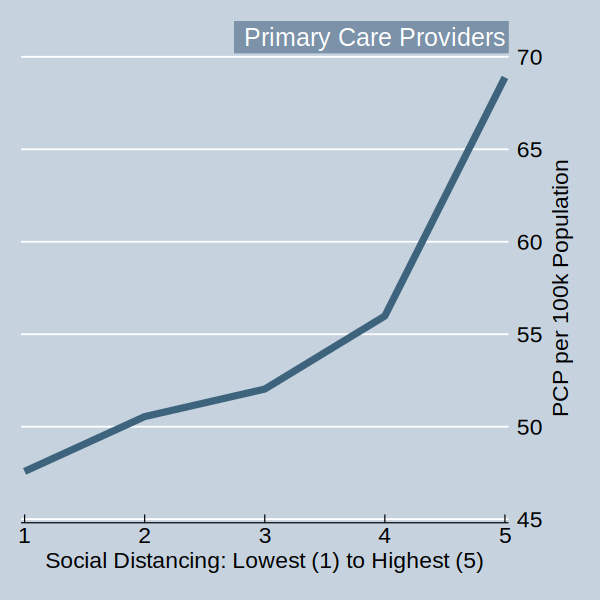

In [44]:
// Comparing Primary Care Physicians per 100,000 population to social distancing
frame change default
foreach var of varlist pcp_rate {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "PCP per 100k Population"
                        line `var' iso5 , note("Primary Care Providers") 
}

---

# Mental Health Providers

For people sequestered at home, mental health providers may play an emerging role. These data are from CMS National Provider Identification (NPI) via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures). It is expressed in rates per 100,000 population.

In [45]:
// Basic descriptive on commuting alone
frame change default
summ mhproviders_rate, d




       Mental Health Providers per 100,000 population
-------------------------------------------------------------
      Percentiles      Smallest
 1%      7.51089              0
 5%     13.71109          4.153
10%     22.33016         4.2155       Obs               2,450
25%     48.25257        4.41326       Sum of Wgt.       2,450

50%     108.2791                      Mean           150.8881
                        Largest       Std. Dev.      149.7092
75%     203.5753       1202.062
90%     321.5745       1355.829       Variance       22412.86
95%     430.9503       1419.854       Skewness       2.616105
99%     745.7847        1420.66       Kurtosis       14.55825




----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(mhprov~e)  mean(mhprov~e)   sem(mhprov~e)
----------+-----------------------------------------------
        1 |            468        129.8275        7.605745
        2 |            486       130.68528        6.615416
        3 |            502       143.27894        5.757351
        4 |            497       153.20643         6.05538
        5 |            497        195.8431        7.293431
----------------------------------------------------------


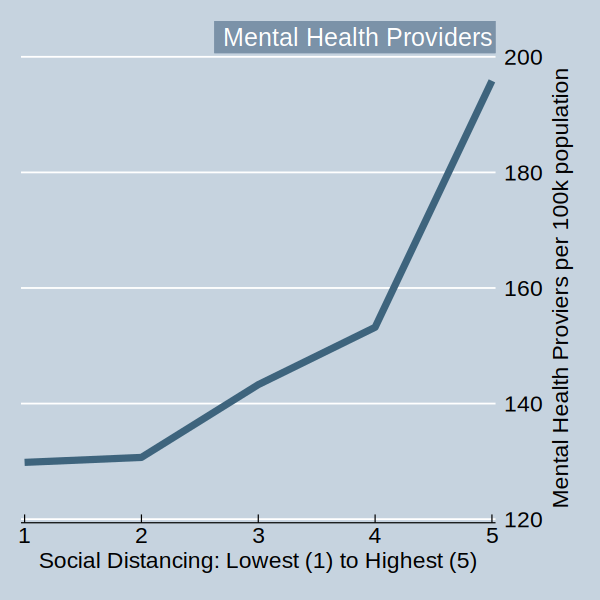

In [46]:
// Comparing mental health provider rate to social distancing
foreach var of varlist mhproviders_rate {
    frame change default
        table iso5, c(count `var' mean `var' sem `var')
            frame put `var' iso5, into(`var')
                frame change `var'
                    collapse (mean) `var', by(iso5)
                        la var mhproviders_rate "Mental Health Proviers per 100k population"
                            line `var' iso5, note("Mental Health Providers")           
}

---
# Health Insurance

Getting hospitalized for Covid-19 is sure to be expensive. After hearing that even some front line nurses in pulmonary infectious disease units in North Carolina do not have health insurance, we wanted to see if there was any association between health insurance status and social distancing. 




----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(uninsu~p)  mean(uninsu~p)   sem(uninsu~p)
----------+-----------------------------------------------
        1 |            499       13.308561        .1971504
        2 |            497       12.334842        .2039521
        3 |            506       10.995156        .2120537
        4 |            503       9.4989416        .1942909
        5 |            502       7.7708062        .1648914
----------------------------------------------------------


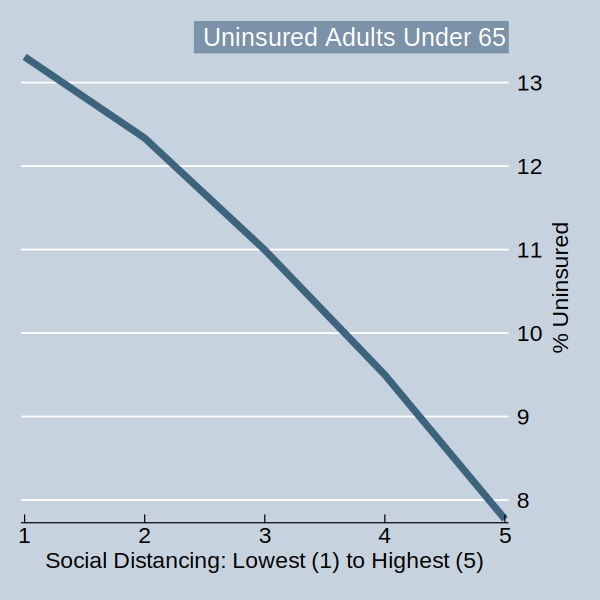

In [47]:
// Comparing percent uninsured to social distancing
frame change default
foreach var of varlist uninsured_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% Uninsured"
                        line `var' iso5 , note("Uninsured Adults Under 65") 
}

Alarmingly, counties with lower social distancing also had more uninsured residents!

---
# Flu Vaccination

We had a hypothesis that counties that were more involved in preventative behaviors would be more likely to self-isolate more thoroughly. To test this, we examined whether earlier flu vaccination rates impacted how much the county was likely to slow down in the current coronavirus outbreak. This is quantified as the percent of annual Medicare enrollees having an annual flu vaccination, as reported by the Robert Wood Johnson Foundation. Since the flu vaccine is free to all Medicare beneficiaries, and this is the elderly age group with the most influenza mortality, this is a convenient metric to test *a priori* how conscientious the population was, on average.




        % Medicare Beneficiaries Getting Flu Vaccine
-------------------------------------------------------------
      Percentiles      Smallest
 1%           19              9
 5%           27             12
10%           31             12       Obs               2,506
25%           37             13       Sum of Wgt.       2,506

50%           43                      Mean           42.21349
                        Largest       Std. Dev.      8.461697
75%           48             62
90%           52             62       Variance       71.60031
95%           54             63       Skewness      -.6005087
99%           57             65       Kurtosis       3.218655

(bin=10, start=9, width=5.6)


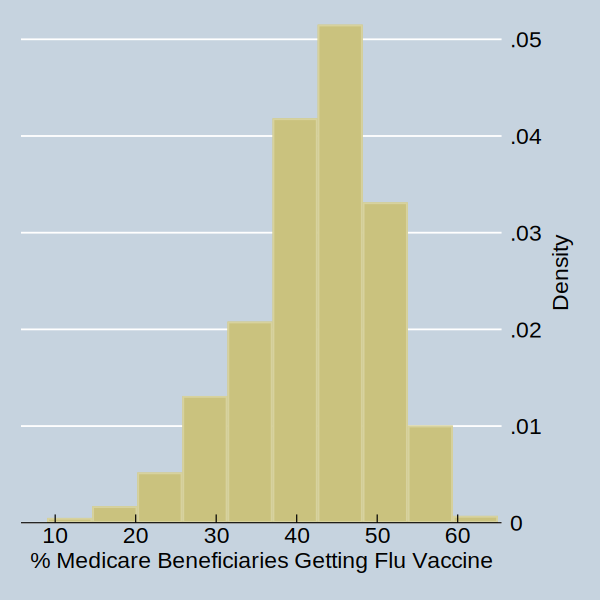

In [48]:
// Basic descriptive on background influenza vaccine
frame change default
summ fluvaccine, d
hist fluvaccine, bin(10)



----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(fluvac~e)  mean(fluvac~e)   sem(fluvac~e)
----------+-----------------------------------------------
        1 |            498       39.339359        .3682052
        2 |            497       41.714287        .3583028
        3 |            506       42.600792        .3745272
        4 |            503       42.842941        .3787197
        5 |            502       44.537849        .3723575
----------------------------------------------------------


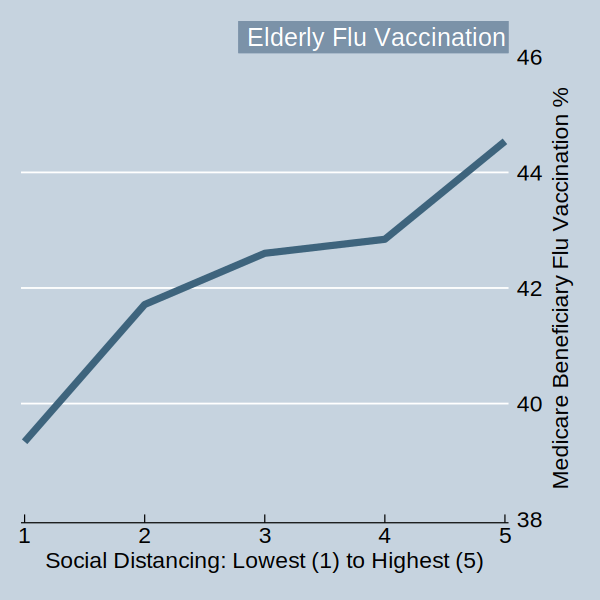

In [49]:
// Comparing background flu vaccination with current social distancing
table iso5, c(count fluvaccine mean fluvaccine sem fluvaccine)

frame put fluvaccine iso5, into(flu)
    frame change flu
        collapse (mean) fluvaccine, by(iso5)
            la var fluvaccine "Medicare Beneficiary Flu Vaccination %"
                line fluvaccine iso5, note("Elderly Flu Vaccination")

--- 
# Income

There is a trend emerging. So, since the places with more social distancing seem to have more health resources, perhaps there are trends in financial means? Income data are from the American Community Survey 5-year estimates via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures).




----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(income80)  mean(income80)   sem(income80)
----------+-----------------------------------------------
        1 |            499       86193.695        636.8371
        2 |            497       88885.761        652.4932
        3 |            506       93321.575        671.9309
        4 |            503       98127.835        856.1122
        5 |            502       112882.41        1424.063
----------------------------------------------------------


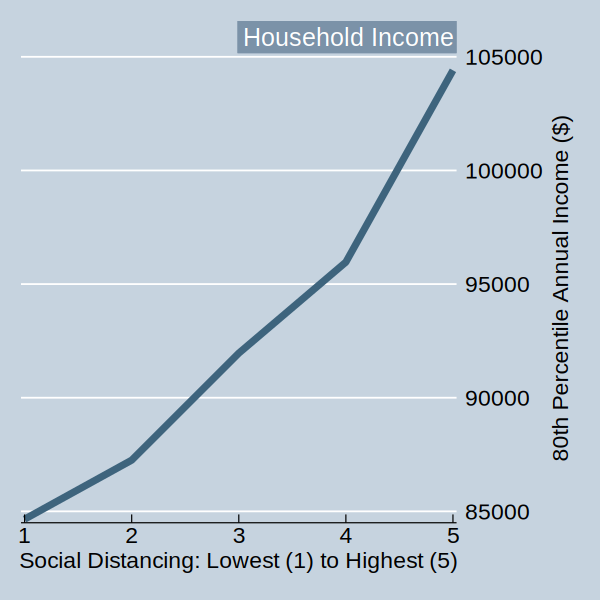

In [50]:
// Comparing income inequality to social distancing
frame change default
foreach var of varlist income80 {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (median) `var', by(iso5)
                    la var `var' "80th Percentile Annual Income ($)"
                        line `var' iso5, note("Household Income")          
}

---
# Income Inequality

So places with more social distancing tend to be wealthier. What about income inequality? Is this merely a matter of have and have-nots? Or does the overall structure of society tell us something. There are many compelling ways to measure income inequality. We are using the ratio of the 80th percentile of income to the 20th percentile. Loosely interpreted, the closer to 4.0, the less inequality there is. Income data are from the American Community Survey 5-year estimates via [RWJF](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/2020-measures).




----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(income~o)  mean(income~o)   sem(income~o)
----------+-----------------------------------------------
        1 |            499       4.8361004        .0371413
        2 |            497        4.628354        .0297515
        3 |            506       4.4730893        .0277805
        4 |            503       4.3748814        .0270911
        5 |            502       4.3956305        .0311182
----------------------------------------------------------


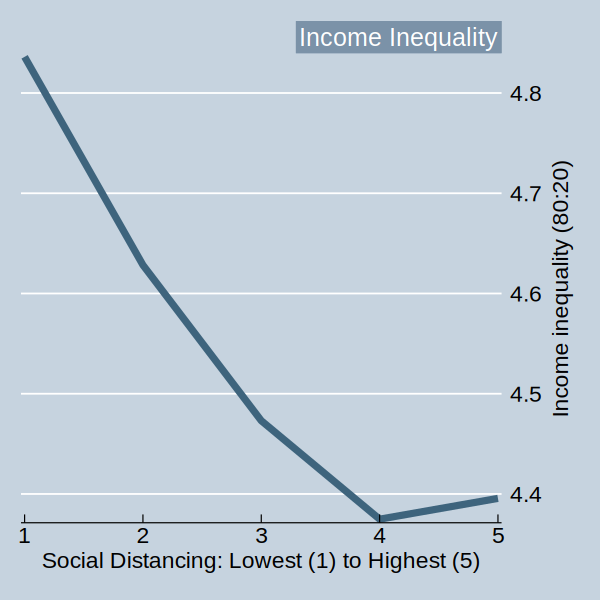

In [51]:
// Comparing income inequality to social distancing
frame change default
foreach var of varlist incomeratio {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "Income inequality (80:20)"
                        line `var' iso5, note("Income Inequality")     
}


---
*fin.*




----------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(airpol)  mean(airpol)   sem(airpol)
----------+-----------------------------------------
        1 |          498     9.2487952       .077229
        2 |          496     9.6044355      .0674843
        3 |          505          9.72      .0686454
        4 |          502     9.6527888      .0863977
        5 |          502     8.9537849      .0825815
----------------------------------------------------


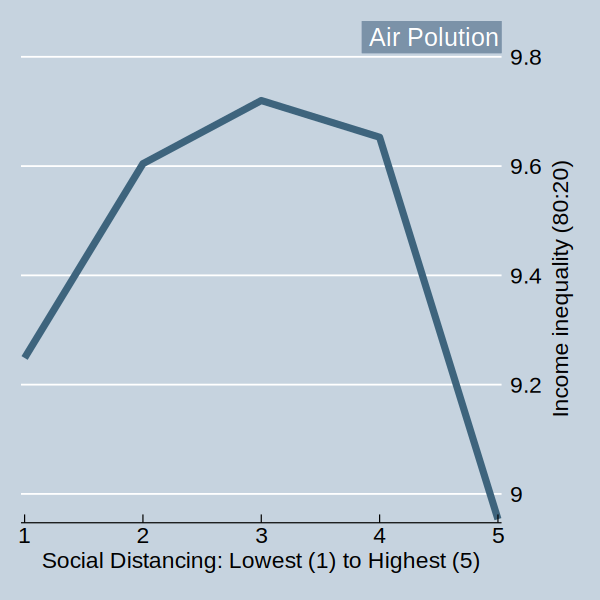

In [52]:
// Comparing income inequality to social distancing
frame change default
foreach var of varlist airpol {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "Income inequality (80:20)"
                        line `var' iso5, note("Air Polution")     
}






----------------------------------------------------------
Social    |
Distancin |
g: Lowest |
(1) to    |
Highest   |
(5)       |    N(drivea~p)  mean(drivea~p)   sem(drivea~p)
----------+-----------------------------------------------
        1 |            499       81.686508        .2380425
        2 |            497       82.117582        .1866779
        3 |            506       81.641934        .2033302
        4 |            503       81.161365        .1792528
        5 |            502       78.121491        .3679001
----------------------------------------------------------


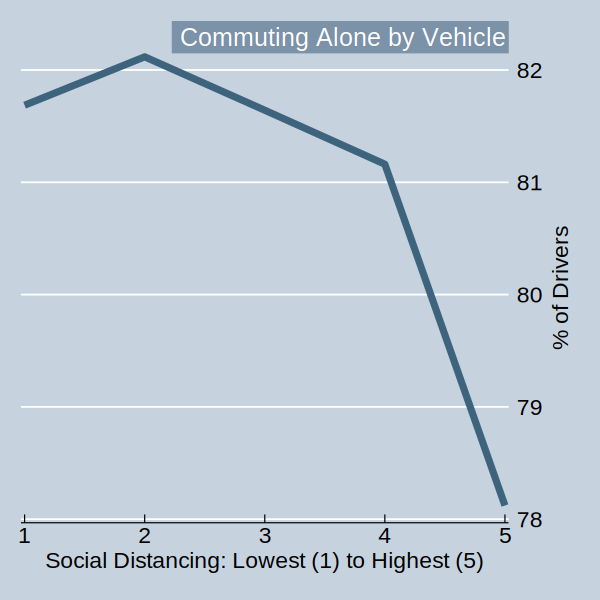

In [53]:

frame change default
foreach var of varlist drivealone_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Drivers"
                        line `var' iso5, note("Commuting Alone by Vehicle")     
}

---


In [54]:
frame change default
foreach var of varlist rucc {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (median) `var', by(iso5)
                    la var `var' "Average RUCC"
                        line `var' iso5, note("Urban-Rural")     
}



variable rucc not found


r(111);
r(111);


In [ ]:
frame change default
foreach var of varlist longcommute_p {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Solo Commuters Driving 30+ mins"
                        line `var' iso5, note("Long Solo Commute")     
}

In [ ]:
frame change default
hist overcrowding
summ overcrowding, d
foreach var of varlist overcrowding {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Households Overcrowded"
                        line `var' iso5, note("Overcrowding")     
}

In [ ]:
frame change default
hist housingprob
foreach var of varlist housingprob {
    table iso5, c(count `var' mean `var' sem `var')
        frame put `var' iso5, into(`var')
            frame change `var'
                collapse (mean) `var', by(iso5)
                    la var `var' "% of Households with overcrowding, high cost, no kitchen/plumbing"
                        line `var' iso5, note("Housing Problems")     
}